# Homer or Peter

In [1]:
import os
iskaggle = os.environ.get('KAGGLE_KERNEL_RUN_TYPE', '')

if iskaggle:
    !pip install -Uqq fastai fastdownload fastcore duckduckgo_search

In [2]:
from duckduckgo_search import ddg_images

def get_screenshot_urls(search_term, max_images=30):
    print(f"Searching for '{search_term}'")
    return L(ddg_images(search_term, max_results=max_images)).itemgot('image')

In [4]:
from time import sleep
from fastai.vision.utils import download_images
from fastcore.all import *

categories = ['homer simpson', 'peter griffin']
top_level_path = Path.home()/'data/homer-or-peter'

# used for testing our model later
test_path = top_level_path/"test.jpg"
test_search_term = 'homer simpson bush'

if not top_level_path.exists():
    top_level_path.mkdir()
    for category in categories:
        dest_path = top_level_path/category
        dest_path.mkdir(exist_ok=True)
        urls = get_screenshot_urls(category, 30)
        download_images(dest=dest_path, urls=urls)
        sleep(10)

Searching for 'homer simpson'
Searching for 'peter griffin'


In [5]:
from fastai.vision.all import *

failed = verify_images(get_image_files(top_level_path))
failed.map(Path.unlink)

(#1) [None]

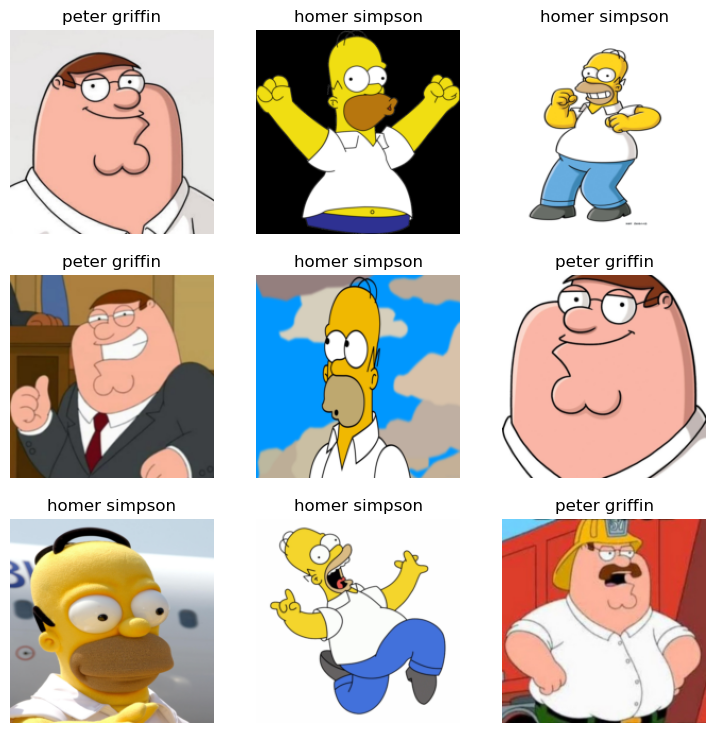

In [6]:
datablock = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.2, seed=34),
    get_y=parent_label,
    item_tfms=[Resize(192, method='squish')]
)

dls = datablock.dataloaders(top_level_path, bs=15)

dls.show_batch()

In [7]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(3)

/home/carver/mambaforge/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/carver/mambaforge/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


epoch,train_loss,valid_loss,error_rate,time
0,1.237907,1.192785,0.454545,00:03


/home/carver/mambaforge/lib/python3.10/site-packages/PIL/Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


epoch,train_loss,valid_loss,error_rate,time
0,0.268178,0.537251,0.272727,00:01
1,0.165059,0.286571,0.181818,00:01
2,0.116204,0.186261,0.181818,00:01


/home/carver/mambaforge/lib/python3.10/site-packages/PIL/Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/carver/mambaforge/lib/python3.10/site-packages/PIL/Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/carver/mambaforge/lib/python3.10/site-packages/PIL/Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


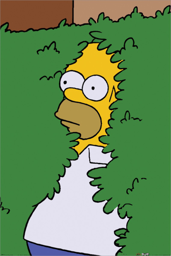

In [8]:
from fastdownload import download_url

image_url = ddg_images(test_search_term, max_results=10)[0]['image']
download_url(image_url, test_path)
Image.open(test_path).to_thumb(256,256)

In [11]:
character,_,probability = learn.predict(PILImage.create(test_path))
print(character)
print(f"{probability[0]:.4f}")

homer simpson
0.9963


Alright! Not bad.

I suspect that the top loss below is due to its color. That would imply that the model is based more on color than other features. As another experiment, I could skew the colors to test that. Another idea is to try character discrimination using multiple characters from the same series (e.g., the Simpsons family).

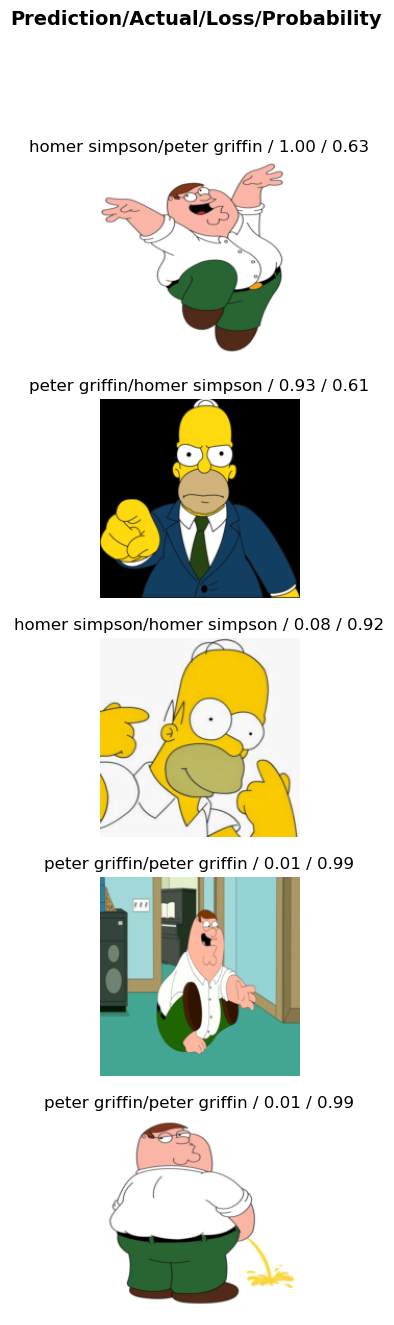

In [12]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_top_losses(5, nrows=5)

In [13]:
from fastai.vision.widgets import *

cleaner = ImageClassifierCleaner(learn)
cleaner

/home/carver/mambaforge/lib/python3.10/site-packages/PIL/Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


In [51]:
# for idx in cleaner.delete(): cleaner.fns[idx].unlink()

### Working to get the model on HuggingFace using Gradio

In [14]:
# This step isn't really necessary, just following along with the tutorial.
learn.export(top_level_path/'homer-or-peter.pkl')

In [15]:
learn = load_learner(top_level_path/'homer-or-peter.pkl')

In [16]:
labels = learn.dls.vocab
def predict(img):
    img = PILImage.create(img)
    pred, pred_idx, probs = learn.predict(img)
    return {labels[i]: float(probs[i]) for i in range(len(labels))}

In [ ]:
# needed to pip install gradio and mamba install scikit-image
import gradio as gr
from fastai.vision.all import *
import skimage

title = "Homer or Peter"
examples = ["homer-or-peter-site/homer_1.jpg",
            "homer-or-peter-site/homer_2.jpg",
            "homer-or-peter-site/homer_3.jpg",
            "homer-or-peter-site/peter_1.jpg",
            "homer-or-peter-site/peter_2.jpg"]
interpretation='default'
enable_queue=True

learn = load_learner(top_level_path/'homer-or-peter.pkl')

labels = learn.dls.vocab
def predict(img):
    img = PILImage.create(img)
    pred, pred_idx, probs = learn.predict(img)
    return {labels[i]: float(probs[i]) for i in range(len(labels))}

gr.Interface(fn=predict,
             inputs=gr.components.Image(shape=(512, 512)),
             outputs=gr.components.Label(num_top_classes=3),
             title=title,
             examples=examples,
             interpretation=interpretation
            ).launch(enable_queue=enable_queue)